### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [240]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
# tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]
tickers = [
    'AAPL', 'AMD', 'MSFT', 'NVDA', 'INTC', 'PLTR',  # Technology
    'AMZN', 'TSLA', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'AXP', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'AMT', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate
    'CVX', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'JNJ', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'BA', 'CAT', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'BHP', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'TMUS', 'GOOG', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples
]

stock_categories = [
    "Technology",
    "Consumer Discretionary",
    "Finance",
    "Real Estate",
    "Energy", 
    "Healthcare",
    "Industrial",
    "Material",
    "Communication",
    "Consumer Staples"
]

In [213]:
# CHANGE THESE!!
appendage = "aapl60"
iteration = 1

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
main_file_path = f"main_{appendage}_{iteration}.ipynb"

rerun_opt, rerun_llm, rerun_coord = True, True, True

#### Functions to save data locally

In [214]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] (I'll provide you the stock ticker) from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                print(f'patched: month {months[i]}\t{ticker}')
            else:
                print(f'skipping: {ticker}')
            
            save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [215]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [216]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [217]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


 32%|███▏      | 19/60 [00:00<00:00, 164.19it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved

100%|██████████| 60/60 [00:00<00:00, 166.51it/s]


Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_dat

  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA


 33%|███▎      | 20/60 [00:00<00:00, 191.19it/s]

Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_dat

 67%|██████▋   | 40/60 [00:00<00:00, 159.46it/s]

Data saved to assets/stock_data.json


100%|██████████| 60/60 [00:00<00:00, 166.94it/s]


skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to as

  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V


 32%|███▏      | 19/60 [00:00<00:00, 188.52it/s]

Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH


100%|██████████| 60/60 [00:00<00:00, 138.62it/s]


Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_da

  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP


 37%|███▋      | 22/60 [00:00<00:00, 209.82it/s]

Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.

 73%|███████▎  | 44/60 [00:00<00:00, 209.92it/s]

Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP


100%|██████████| 60/60 [00:00<00:00, 210.68it/s]


Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


 35%|███▌      | 21/60 [00:00<00:00, 205.80it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved

100%|██████████| 60/60 [00:00<00:00, 206.45it/s]


Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V


 30%|███       | 18/60 [00:00<00:00, 179.84it/s]

Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_

 68%|██████▊   | 41/60 [00:00<00:00, 203.95it/s]

Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG


100%|██████████| 60/60 [00:00<00:00, 198.45it/s]


Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD


 33%|███▎      | 20/60 [00:00<00:00, 172.23it/s]

Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT


 65%|██████▌   | 39/60 [00:00<00:00, 179.98it/s]

Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_da

100%|██████████| 60/60 [00:00<00:00, 187.61it/s]


Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved

 38%|███▊      | 23/60 [00:00<00:00, 221.84it/s]

skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to asse

 77%|███████▋  | 46/60 [00:00<00:00, 221.07it/s]

Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS


100%|██████████| 60/60 [00:00<00:00, 218.87it/s]


Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN


 33%|███▎      | 20/60 [00:00<00:00, 197.87it/s]

Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_da

 67%|██████▋   | 40/60 [00:00<00:00, 171.50it/s]

Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON


100%|██████████| 60/60 [00:00<00:00, 188.36it/s]


Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC


 23%|██▎       | 14/60 [00:00<00:00, 138.38it/s]

Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: WELL
Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.

 60%|██████    | 36/60 [00:00<00:00, 186.00it/s]

Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_da

100%|██████████| 60/60 [00:00<00:00, 171.68it/s]


Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved

 37%|███▋      | 22/60 [00:00<00:00, 213.45it/s]

Data saved to assets/stock_data.json
skipping: SPG
Data saved to assets/stock_data.json
skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data

 73%|███████▎  | 44/60 [00:00<00:00, 179.80it/s]

Data saved to assets/stock_data.json
skipping: HON
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: NEM
Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP


100%|██████████| 60/60 [00:00<00:00, 187.70it/s]


Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG
Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json


  0%|          | 0/60 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: INTC
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: AMZN
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: AXP
Data saved to assets/stock_data.json
skipping: BAC
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: MS
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: SCHW
Data saved to assets/stock_data.json
skipping: AMT
Data saved to assets/stock_data.json
skipping: PLD
Data saved

 37%|███▋      | 22/60 [00:00<00:00, 218.86it/s]

skipping: PSA
Data saved to assets/stock_data.json
skipping: EQR
Data saved to assets/stock_data.json
skipping: CVX
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: DUK
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
skipping: SLB
Data saved to assets/stock_data.json
skipping: JNJ
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: ABBV
Data saved to assets/stock_data.json
skipping: MDT
Data saved to assets/stock_data.json
skipping: BA
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: DE
Data saved to assets/stock_data.json
skipping: GD
Data saved to assets/stock_data.json
skipping: HON
Data saved to asse

 73%|███████▎  | 44/60 [00:00<00:00, 217.76it/s]

Data saved to assets/stock_data.json
skipping: LIN
Data saved to assets/stock_data.json
skipping: APD
Data saved to assets/stock_data.json
skipping: FCX
Data saved to assets/stock_data.json
skipping: MLM
Data saved to assets/stock_data.json
skipping: TMUS
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: DIS
Data saved to assets/stock_data.json
skipping: VZ
Data saved to assets/stock_data.json
skipping: CMCSA
Data saved to assets/stock_data.json
skipping: COST
Data saved to assets/stock_data.json
skipping: PEP
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: KO
Data saved to assets/stock_data.json
skipping: PG


100%|██████████| 60/60 [00:00<00:00, 218.34it/s]

Data saved to assets/stock_data.json
skipping: MO
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Initial stock introductions

In [218]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [219]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        
        missing_tickers = []
        missing_indices = []
        for i, ticker in enumerate(tickers):
            ticker_data = data_loaded[month-1][ticker]
            if "price" not in ticker_data:
                missing_tickers.append(ticker)
                missing_indices.append(i)

        if missing_indices:
            prices = get_stock_price(missing_tickers, datetime_obj)

            for i, (ticker, j) in enumerate(zip(missing_tickers, missing_indices)):
                print(f'{i}: ({ticker}, {j})')
                data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json
Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [220]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%***********************]  60 of 60 completed


#### Historical ticker prices

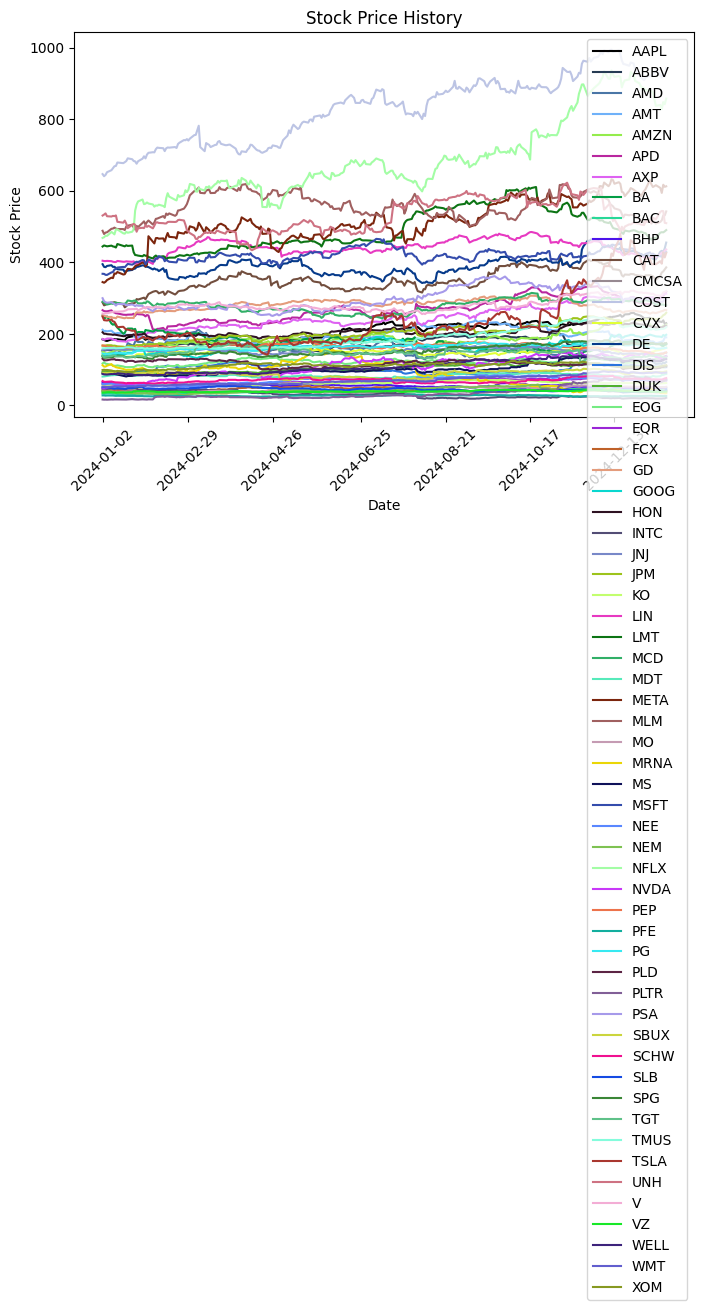

In [221]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 19.2%
Annual volatility: 10.5%
Sharpe Ratio: 1.65


AAPL     0.156389
ABBV     0.113929
AMD      0.357081
AMT      0.123932
AMZN     0.243022
APD      0.167442
AXP      0.241339
BA       0.197038
BAC      0.231008
BHP      0.200206
CAT      0.275366
CMCSA    0.167723
COST     0.147400
CVX      0.146778
DE       0.200534
DIS      0.156724
DUK      0.097016
EOG      0.135606
EQR      0.178846
FCX      0.296947
GD       0.141462
GOOG     0.186858
HON      0.156148
INTC     0.460220
JNJ      0.071424
JPM      0.223166
KO       0.072802
LIN      0.140534
LMT      0.069106
MCD      0.121550
MDT      0.147875
META     0.208027
MLM      0.222733
MO       0.095666
MRNA     0.371218
MS       0.277263
MSFT     0.179704
NEE      0.164882
NEM      0.241409
NFLX     0.186522
NVDA     0.298169
PEP      0.075769
PFE      0.139916
PG       0.058390
PLD      0.235620
PLTR     0.505061
PSA      0.187942
SBUX     0.198563
SCHW     0.171010
SLB      0.220837
SPG      0.217306
TGT      0.194613
TMUS     0.095101
TSLA     0.455761
UNH      0.091315
V        0

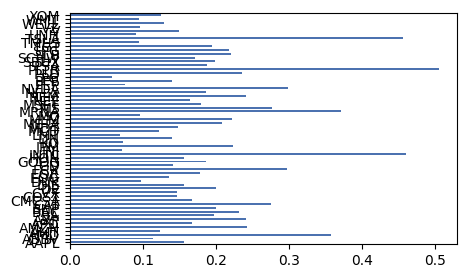

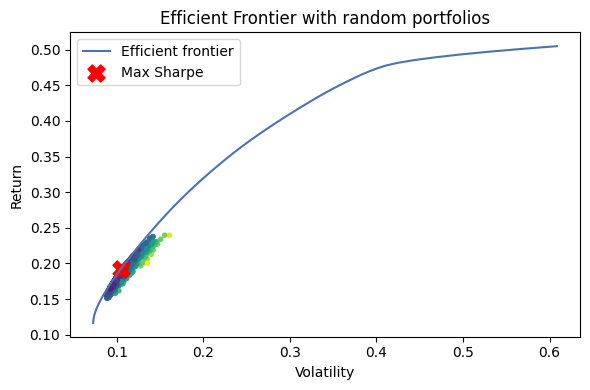

In [222]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [223]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [224]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [225]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[*********************100%***********************]  60 of 60 completed


In [226]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

AAPL        ABBV         AMD         AMT        AMZN         APD         AXP          BA        BAC        BHP         CAT      CMCSA        COST         CVX          DE        DIS        DUK         EOG        EQR        FCX          GD        GOOG         HON       INTC         JNJ         JPM         KO         LIN         LMT         MCD        MDT        META         MLM         MO        MRNA         MS        MSFT        NEE        NEM        NFLX       NVDA         PEP        PFE          PG         PLD       PLTR         PSA       SBUX       SCHW        SLB         SPG         TGT        TMUS        TSLA         UNH           V         VZ       WELL        WMT        XOM
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-12-01  190.307678  137.060013  121.389999  201.975693  147.029999  263.875183  171.301300  233.869995  30.191700  59.699661  252.706909  40.636681  579.607483  138.829086  362.007568  91.450256  89.005692  117.740883  55.721298  38.601402  243.451187  132.842697  193.644821  43.161942  153.519714  152.395035  56.902115  406.739136  437.944641  279.194122  77.369759  323.583954  464.845337  38.324417   79.830002  78.047142  371.730255  57.495758  40.197464  465.739990  46.747635  163.455658  27.244608  148.951782  113.803802  20.270000  253.026291  96.678337  62.238167  50.857098  120.769409  130.896698  150.036591  238.830002  538.725281  254.504654  35.540035  87.397285  50.649208  99.592743
2023-12-04  188.506485  137.767227  118.570000  200.305908  144.839996  261.465179  170.798492  234.869995  30.055174  58.201008  250.728622  41.474258  582.358521  138.886612  362.125366  90.887215  89.092163  117.169319  55.864079  36.997929  245.908218  130.162308  194.212708  41.790310  154.004364  153.512451  56.834187  401.740082  439.191986  279.360077  77.147301  318.802185  461.742065  38.234455   79.870003  78.355904  366.400116  57.009903  39.553524  453.899994  45.493095  163.891708  27.593296  148.366364  115.795799  18.400000  256.165344  95.118996  61.725754  50.507629  122.672546  129.857529  150.578583  235.580002  539.828064  252.509903  35.042583  87.748993  50.636082  99.051224
2023-12-05  192.477051  138.168640  118.379997  201.918121  146.880005  253.596558  168.264877  234.160004  29.821131  57.878510  251.161682  40.059048  588.453430  136.959641  354.479126  89.682098  88.842361  116.169106  55.445263  35.974854  244.621201  131.916016  192.832184  41.365990  153.684509  153.493027  56.921524  399.102264  434.855499  279.760406  76.238091  317.078796  456.788727  38.297428   78.279999  77.352455  369.754974  56.582355  38.919342  455.149994  46.552799  162.728912  27.414240  143.195084  114.179100  18.299999  255.718201  93.111374  61.321735  49.366383  122.606918  129.051453  151.761139  238.720001  541.777527  252.678619  35.392635  87.807602  51.105362  97.126869
2023-12-06  191.382416  139.898499  116.820000  202.253967  144.520004  252.880325  165.139725  236.889999  29.772373  58.286373  251.929367  40.136066  590.475464  136.643265  358.797943  90.383430  90.254692  114.073395  55.464302  35.660069  245.654694  130.959427  193.654617  40.724583  151.813721  151.880081  56.863304  395.486359  437.944641  280.072815  76.450882  316.241974  458.012177  37.208874   80.599998  76.619179  366.062592  58.496613  38.724205  446.730011  45.49

#### Main class to integrate the LLM with the Portfolio Optimization model

In [227]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, verbose=False):
        messages = [
            {"role": "system", "content": "You're a very advanced . Deep understanding . When you see a news, you will know whether or not it will have a strong impact on your trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        if iter == 0:
            stock_prices = f"The stock prices today are:\n"
            for i, ticker in enumerate(tickers):
                ticker_close = month_data[ticker]['price']
                stock_prices += f"{ticker} = {ticker_close}"
                if i != len(tickers) - 1:
                    stock_prices += ", "
            stock_prices += "\n"

            stock_news = ""
            for ticker in tickers:
                ticker_news = month_data[ticker]['news']
                stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            "2. Any patterns in recent price movements.\n"
            "3. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.optimization_plan != [0.0] * self.n:
            current_prompt += (
                "Also, here is the **current optimizer plan**:\n"
                f"{self.optimization_plan}\n\n"
                "Decide whether you agree with the optimizer's plan. If you do, make any necessary adjustments to "
                "move your portfolio allocation closer to it.\n\n"
            )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. **Explain your decision process**. Discuss your reasoning and any trade-offs you considered.\n"
            "2. **Provide a recommended investment decision** for each stock in terms of confidence, choosing from "
            "one of the following 7 levels:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "Take a deep breath and work on this problem step-by-step.\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format()
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter} prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        missing_tickers = tickers
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                else: # "MISSING TICKER"
                    new_message = f"You missed a few tickers: {missing_tickers}. Give the confidence levels for them: "

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} RETRY PROMPT: \n{new_message}\n")

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"[DEBUG]\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            for stock in missing_tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                else:
                    retry = True
                    if verbose:
                        print("[DEBUG]\tInvalid format, retrying.")
                        print(f"[DEBUG]\tfetched weights: {result_dict}")
                    continue

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print("[DEBUG]\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if list(result_dict.keys()) != tickers:
                missing_tickers = list(set(tickers)-set(list(result_dict.keys()))) 
                print(f"missing {missing_tickers = }")
                if verbose: 
                    print("[DEBUG]\tInvalid output: not every ticker was outputted")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"[DEBUG]\tfetched weights: {result_dict = }")
                retry = False
            

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):

            self.summarize()
            
            self.conversation_history = []

            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df)
                    print("\n```\n")

        return self.plan_histories

In [228]:
CoordFW = CoordinationFramework(
    mu, S, 0.449055, penalty=1, iteration=20, verbose=False)
# appl15 0.93703
# morgan15 0.449055
# chev15 0.688154

#### Run the optimizer only, as baseline

In [229]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.020222953337075522,
  0.020465662570320692,
  0.010710753818603811,
  0.01948687290014251,
  0.019423716171883324,
  0.016745175945087832,
  0.012769398757623781,
  0.019537510967435612,
  0.012520101826574984,
  0.012809282207960166,
  0.014039413621379155,
  0.017523187766191967,
  0.01935459039528007,
  0.016607363440728204,
  0.012761828089338975,
  0.015550608381678212,
  0.018680403948538957,
  0.01728463775631865,
  0.01523158569935737,
  0.0060406494447108,
  0.020580747517890408,
  0.021260343099651975,
  0.0200279815122321,
  0.011619113700410572,
  0.018286996601887304,
  0.01922157927581897,
  0.019619696860387274,
  0.02212604620378976,
  0.021229600948256794,
  0.02106465718883753,
  0.01576596778111562,
  0.018614771796081807,
  0.017702371670528235,
  0.016485194226048407,
  0.007839857964345987,
  0.013942764728359626,
  0.02228045612204194,
  0.014936171785322297,
  0.011348445955232763,
  0.015452476498351974,
  0.01537548235622637,
  0.019566339067277394,
  0.02

#### Run the LLM only, as baseline

In [230]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, True)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)

llm_histories


# month 0 iter 0 prompt: 
Recent reports indicate:
For AAPL:
Apple Inc., traded under the ticker AAPL, is one of the world's largest companies, with a market cap of approximately $3.68 trillion as of January 2025. The company's primary revenue source is the iPhone, which accounts for about 48.7% of its total sales. Apple also generates significant revenue from its services segment and other products like Mac, iPad, and Apple Watch. The company has recently seen strong performance, with a 32.6% year-to-date increase in stock price, outpacing the S&P 500 and Nasdaq Composite indexes. Analysts, such as those at Wedbush, predict a strong holiday season and potential market cap of $4 trillion in early 2025, driven by AI-driven upgrades and a robust installed base of iOS devices[1][5].

For AMD:
Advanced Micro Devices (AMD) is a semiconductor company known for designing and developing CPUs, GPUs, and other high-performance computing solutions. For 2025, analysts are bullish on AMD's stock, 

[[0.019607843137254912,
  0.02450980392156864,
  0.019607843137254912,
  0.029411764705882366,
  0.004901960784313728,
  0.019607843137254912,
  0.02450980392156864,
  0.014705882352941183,
  0.009803921568627456,
  0.014705882352941183,
  0.02450980392156864,
  0.004901960784313728,
  0.02450980392156864,
  0.019607843137254912,
  0.02450980392156864,
  0.019607843137254912,
  0.02450980392156864,
  0.019607843137254912,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.019607843137254912,
  0.019607843137254912,
  0.014705882352941183,
  0.019607843137254912,
  0.019607843137254912,
  0.014705882352941183,
  0.009803921568627456,
  0.02450980392156864,
  0.014705882352941183,
  0.009803921568627456,
  0.019607843137254912,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,
  0.014705882352941183,

#### Run the coordinator algorithm

In [231]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord


# month 0 iter 0 prompt: 
Recent reports indicate:
For AAPL:
Apple Inc., traded under the ticker AAPL, is one of the world's largest companies, with a market cap of approximately $3.68 trillion as of January 2025. The company's primary revenue source is the iPhone, which accounts for about 48.7% of its total sales. Apple also generates significant revenue from its services segment and other products like Mac, iPad, and Apple Watch. The company has recently seen strong performance, with a 32.6% year-to-date increase in stock price, outpacing the S&P 500 and Nasdaq Composite indexes. Analysts, such as those at Wedbush, predict a strong holiday season and potential market cap of $4 trillion in early 2025, driven by AI-driven upgrades and a robust installed base of iOS devices[1][5].

For AMD:
Advanced Micro Devices (AMD) is a semiconductor company known for designing and developing CPUs, GPUs, and other high-performance computing solutions. For 2025, analysts are bullish on AMD's stock, 

[[0.019867574229513366,
  0.022427953236379847,
  0.015111474470277508,
  0.02437758279153466,
  0.012150882476185563,
  0.01812868553351952,
  0.018579821330031394,
  0.017085828654449506,
  0.011138099693775293,
  0.013721714274711784,
  0.01921482876190908,
  0.013639642663583786,
  0.021872417148859537,
  0.018059779281339707,
  0.01857603599588899,
  0.01753140175181471,
  0.02153532392548898,
  0.018398416439134927,
  0.014932866020410386,
  0.010337397893087102,
  0.017607446929676904,
  0.01794724472055769,
  0.017331063926847752,
  0.013126630020936988,
  0.016460571471675352,
  0.019366887198885088,
  0.01712692160092534,
  0.020819120662870484,
  0.020370898035104,
  0.017849401765150465,
  0.015200057061289511,
  0.019063483459016504,
  0.01616825900599582,
  0.010681621503268105,
  0.013676026543148596,
  0.014288455534911515,
  0.01601827684150877,
  0.01722418345363675,
  0.012991296148348083,
  0.01748233581015159,
  0.015004814348844887,
  0.017100242704370397,
  0.014

#### Display results

In [232]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

status  all AAPL   all AMD  all MSFT  all NVDA  all INTC  all PLTR  all AMZN  all TSLA  all SBUX   all TGT  all NFLX   all MCD   all AXP   all BAC   all JPM    all MS     all V  all SCHW   all AMT   all PLD  all WELL   all SPG   all PSA   all EQR   all CVX   all XOM   all DUK   all NEE   all EOG   all SLB   all JNJ   all UNH   all PFE  all MRNA      all ABBV   all MDT    all BA   all CAT   all LMT    all DE    all GD   all HON   all BHP   all NEM   all LIN   all APD   all FCX   all MLM  all TMUS  all GOOG  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG        all MO  llm AAPL   llm AMD  llm MSFT  llm NVDA  llm INTC  llm PLTR  llm AMZN  llm TSLA  llm SBUX   llm TGT  llm NFLX   llm MCD   llm AXP   llm BAC   llm JPM    llm MS     llm V  llm SCHW   llm AMT   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm CVX   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm JNJ   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT    llm BA   llm CAT   llm LMT    llm DE    llm GD   llm HON   llm BHP   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm TMUS  llm GOOG  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO  opt AAPL       opt AMD      opt MSFT  opt NVDA      opt INTC  opt PLTR      opt AMZN      opt TSLA      opt SBUX       opt TGT  opt NFLX       opt MCD       opt AXP       opt BAC   opt JPM    opt MS         opt V      opt SCHW       opt AMT       opt PLD  opt WELL       opt SPG   opt PSA       opt EQR   opt CVX   opt XOM       opt DUK   opt NEE       opt EOG   opt SLB       opt JNJ   opt UNH   opt PFE      opt MRNA      opt ABBV   opt MDT        opt BA       opt CAT       opt LMT    opt DE        opt GD       opt HON   opt BHP       opt NEM       opt LIN   opt APD       opt FCX   opt MLM      opt TMUS  opt GOOG      opt META       opt DIS        opt VZ     opt CMCSA  opt COST   opt PEP   opt WMT        opt KO    opt PG        opt MO
0    CONVERGED month 0 iter 0  0.019868  0.022428  0.015111  0.024378  0.012151  0.018129  0.018580  0.017086  0.011138  0.013722  0.019215  0.013640  0.021872  0.018060  0.018576  0.017531  0.021535  0.018398  0.014933  0.010337  0.017607  0.017947  0.017331  0.013127  0.016461  0.019367  0.017127  0.020819  0.020371  0.017849  0.015200  0.019063  0.016168  0.010682  1.367603e-02  0.014288  0.016018  0.017224  0.012991  0.017482  0.015005  0.017100  0.014743  0.016580  0.012682  0.010295  0.017654  0.018246  0.012295  0.017158  0.015549  0.017105  0.019168   0.012731  0.020850  0.017297  0.020421  0.014996  0.017378  1.525926e-02  0.019512  0.024390  0.019512  0.029268  0.004878  0.019512  0.024390  0.014634  0.009756  0.014634  0.024390  0.009756  0.024390  0.019512  0.024390  0.019512  0.024390  0.019512  0.014634  0.014634  0.014634  0.014634  0.014634  0.014634  0.014634  0.019512  0.014634  0.019512  0.019512  0.014634  0.014634  0.019512  0.014634  0.004878  0.019512  0.014634  0.009756  0.019512  0.014634  0.019512  0.014634  0.014634  0.004878  0.014634  0.014634  0.014634  0.019512  0.019512  0.014634  0.019512  0.014634  0.019512  0.014634   0.014634  0.019512  0.014634  0.019512  0.014634  0.014634  0.014634  0.020223  2.046566e-02  1.071075e-02  0.019487  1.942372e-02  0.016745  1.276940e-02  1.953751e-02  1.252010e-02  1.280928e-02  0.014039  1.752319e-02  1.935459e-02  1.660736e-02  0.012762  0.015551  1.868040e-02  1.728464e-02  1.523159e-02  6.040649e-03  0.020581  2.126034e-02  0.020028  1.161911e-02  0.018287  0.019222  1.961970e-02  0.022126  2.122960e-02  0.021065  1.576597e-02  0.018615  0.017702  1.648519e-02  7.839858e-03  0.013943  2.228046e-02  1.493617e-02  1.134845e-02  0.015452  1.537548e-02  1.956634e-02  0.024608  1.852518e-02  1.073046e-02  0.005955  1.579540e-02  0.016980  9.955611e-03  0.014804  1.646407e-02  1.469755e-02  2.370188e-02  1.082751e-02  0.022188  0.019960  0.021330  1.535820e-02  0.020121  1.588437e-02
1    CONVERGED month 1 iter 0  0.013679  0.021709  0.01

In [233]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [234]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

#### Graph the results

In [239]:
categories

['all', 'llm', 'opt']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


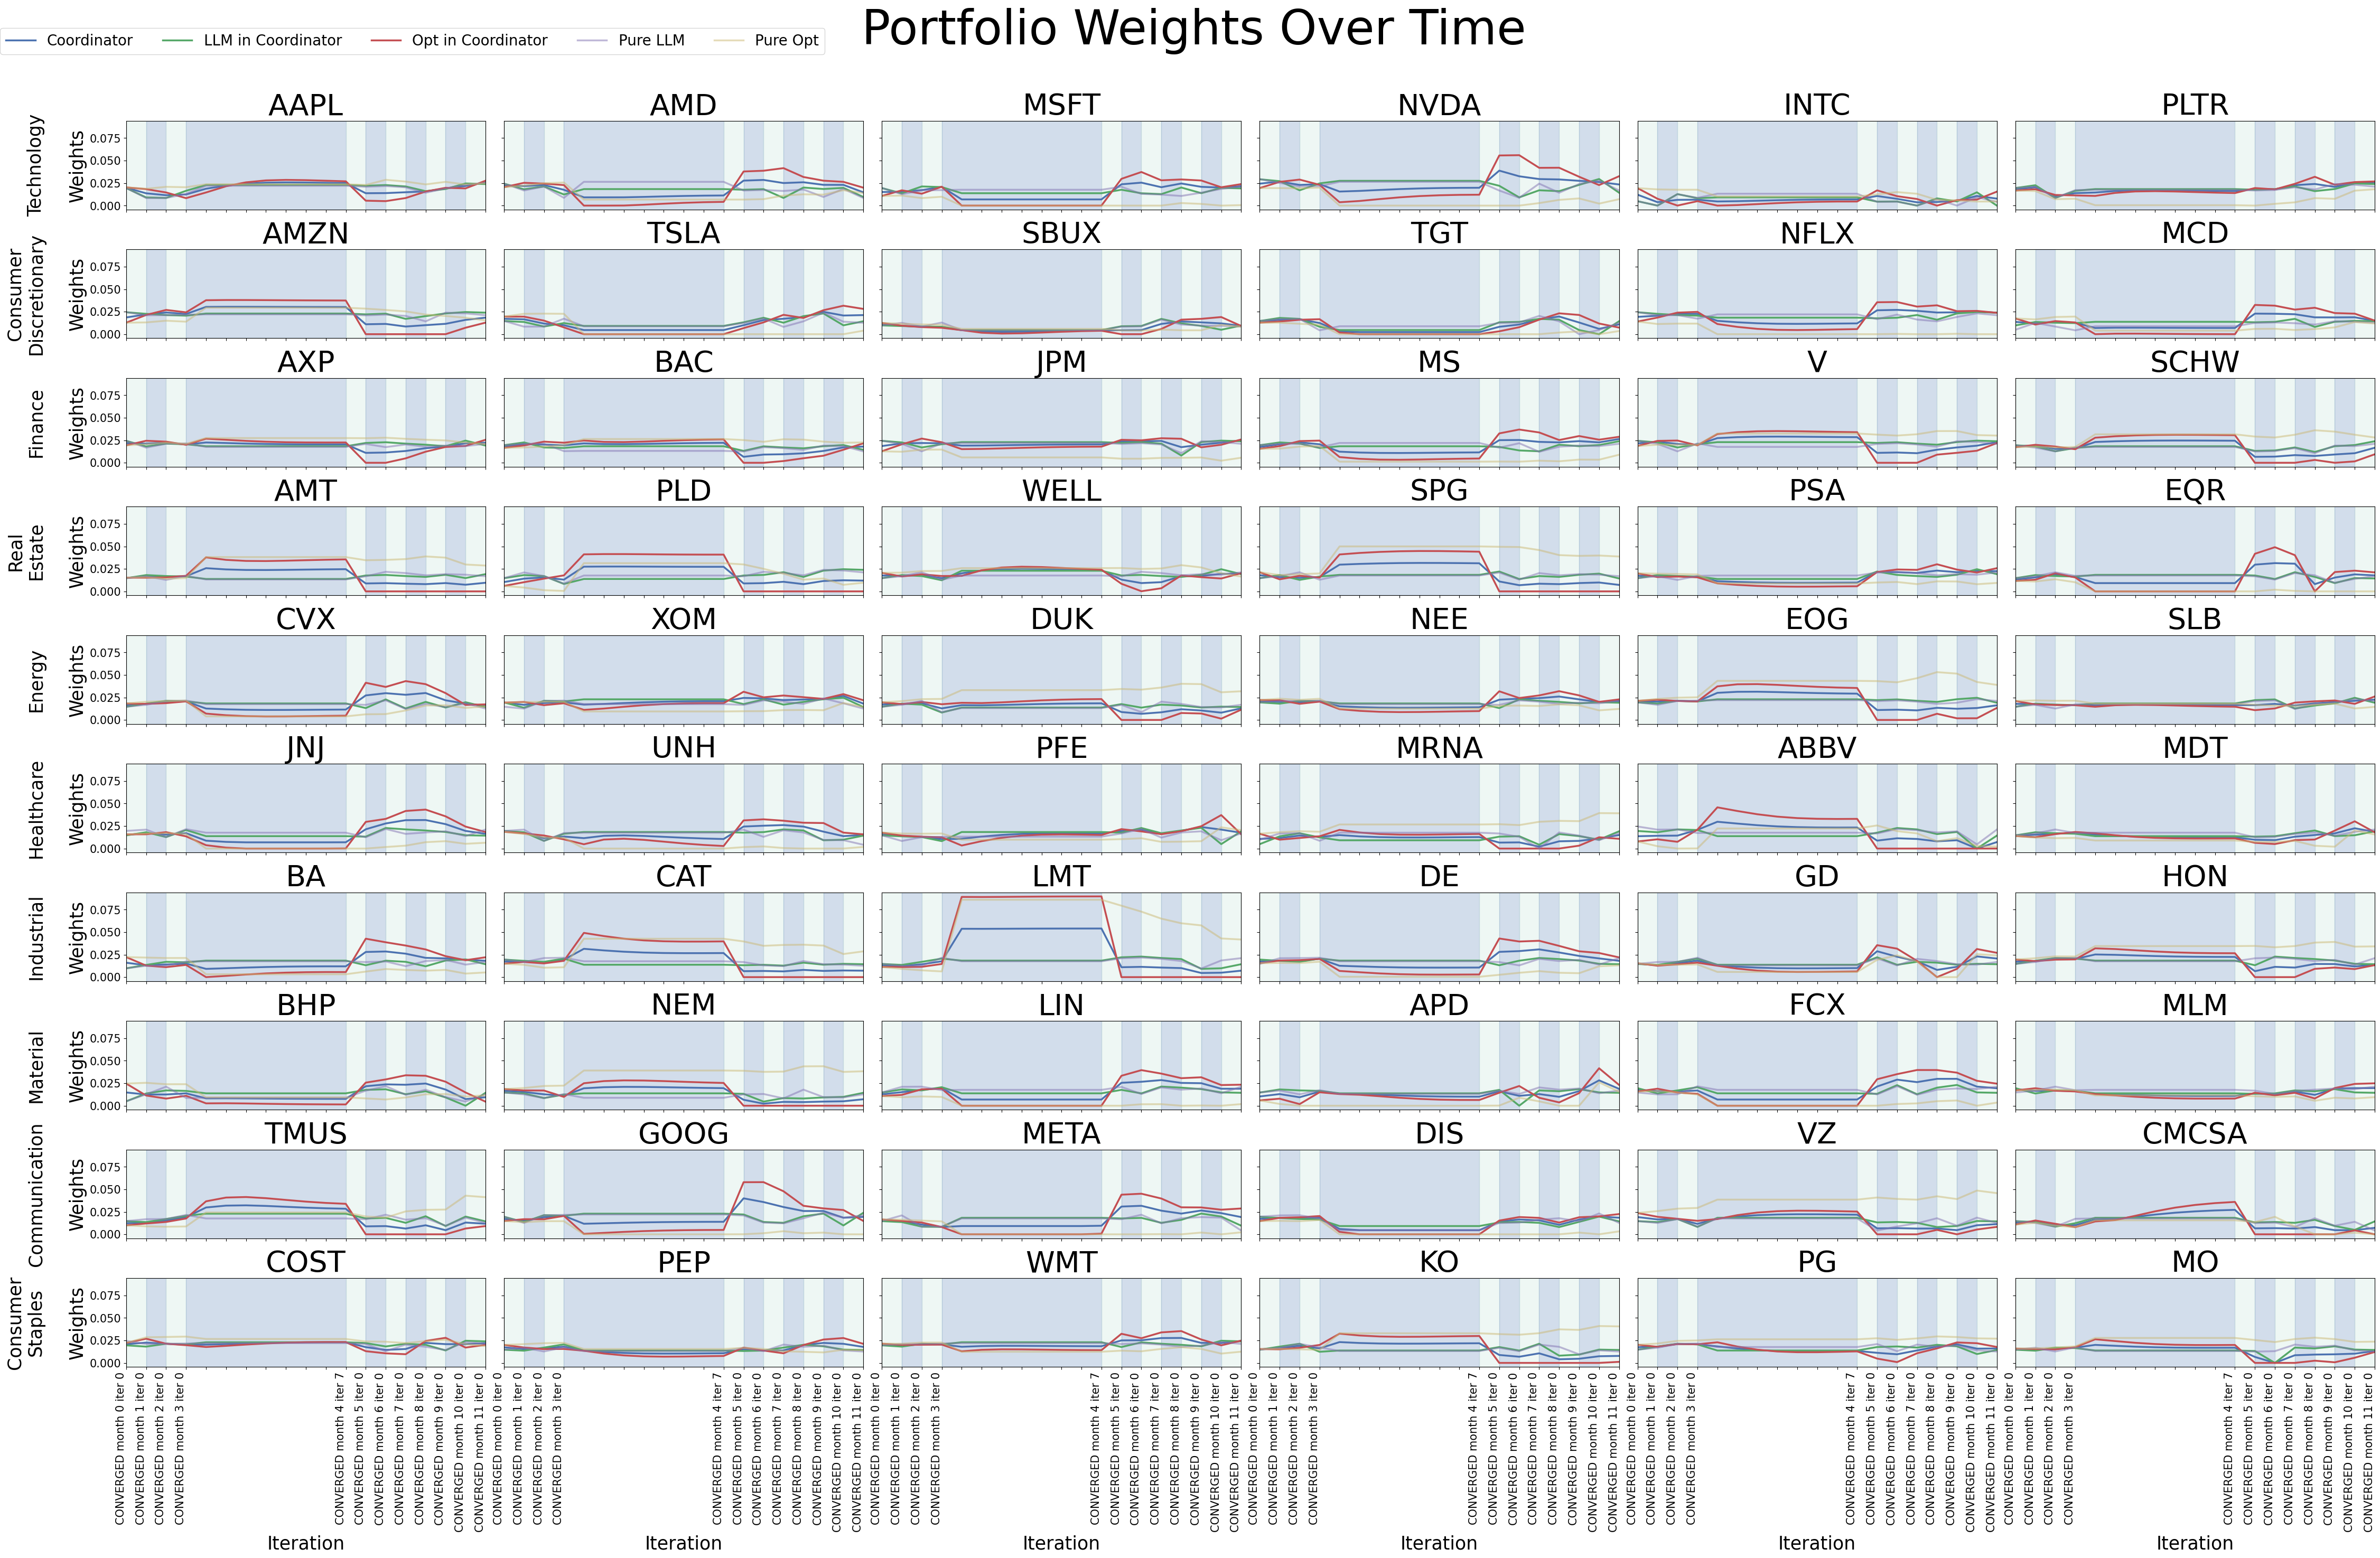

In [241]:
rows = 10
columns = 6

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time\n", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i in range(rows * columns):

    isEmpty = False

    try:
        ticker = tickers[i]
    except:
        ticker = None
        isEmpty = True
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if ticker:
        # Plot lines
        if i == 0:
            axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)
        else:
            axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], linewidth=2.5, alpha=0.5)
        
        # Title and tick parameters
        axes[i].set_title(f'{ticker}', fontsize=40)

    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)

    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        cat = '\n'.join(stock_categories[i//columns].split())
        axes[i].set_ylabel(f"{cat}\n\nWeights", fontsize=25)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=25)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
# fig.legend(loc=(0.00, 0.95), ncol=2, fontsize=20)
fig.legend(loc=(0.00, 0.965), ncol=5, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300) # , bbox_inches='tight'  
plt.show()

#### Backtesting
Seeing how the strategies perform based on historical data

In [242]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)
all_weights = ["all " + ticker for ticker in tickers]

# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

11587.18080817984
11204.98954651097
11700.80286051569


#### Plot the backtesting

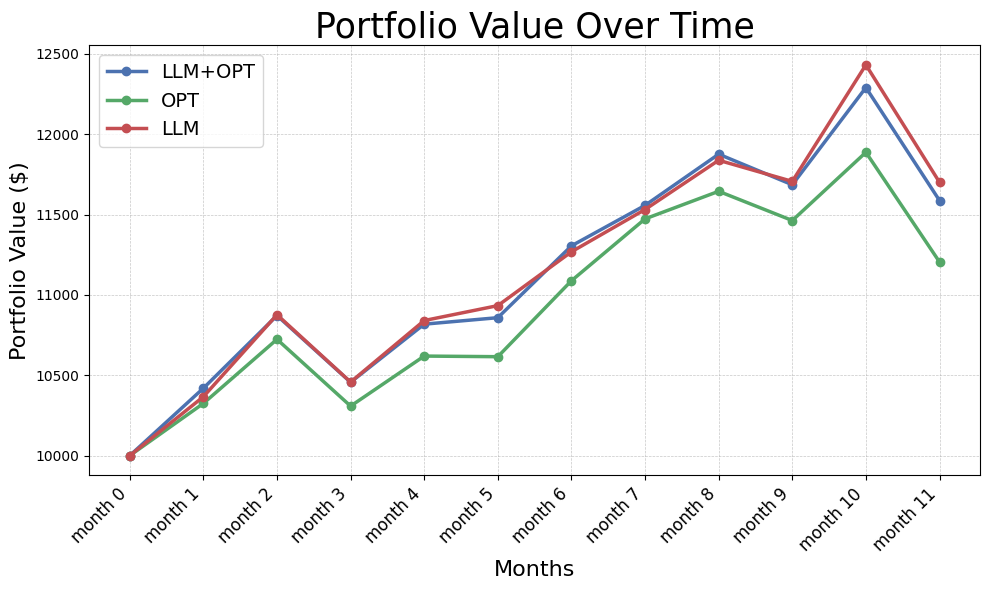

In [243]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=500, bbox_inches='tight')  
plt.show()